# TA-11 — Implementasi Naive Bayes (Customer Behaviour Prediction)

**Studi Kasus: Customer Behaviour Prediction**  
Himpunan data ini difungsikan sebagai instrumen studi komparatif untuk evaluasi kinerja berbagai algoritma Machine Learning, yang mencakup rekam data **400 pelanggan** dengan atribut demografis (**Gender, Age**) dan finansial (**EstimatedSalary**). Fokus analisis terletak pada pemodelan variabel dependen keputusan pembelian (**Purchased**) berdasarkan fitur prediktor yang tersedia guna mengidentifikasi pola perilaku konsumen secara kuantitatif.

**Dataset (Kaggle):** Customer Behaviour — denisadutca  


## Langkah 1 — Import Required Libraries


In [17]:

# import required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics


## Langkah 2 — Memuat dan Memeriksa Data

In [18]:

# ========== LOAD DATASET ==========

from google.colab import files
import io
import pandas as pd

# Upload file (akan muncul tombol upload)
uploaded = files.upload()

# Ambil nama file pertama yang di-upload
filename = list(uploaded.keys())[0]
print(f"File uploaded: {filename}")

# Load CSV ke DataFrame
data = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"Shape: {data.shape}")
data.head()


Saving Customer_Behaviour.csv to Customer_Behaviour (1).csv
File uploaded: Customer_Behaviour (1).csv
Shape: (400, 5)


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [19]:

df = pd.DataFrame(data)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


### Ringkas Pemeriksaan Awal
- Periksa nilai hilang (NaN)
- Lihat jumlah nilai unik tiap kolom
- Lihat statistik deskriptif
- Drop kolom `User ID` karena tidak relevan untuk prediksi

In [20]:

# Check missing value
df.isnull().sum().to_frame('NaN value').T


,User ID,Gender,Age,EstimatedSalary,Purchased
NaN value,0,0,0,0,0


In [21]:

# check count of unique values in each columns
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")


User ID: 400
Gender: 2
Age: 43
EstimatedSalary: 117
Purchased: 2


In [22]:

# more details
df.describe(include=[np.number]).T


,count,mean,std,min,25%,50%,75%,max
User ID,400.0,1.569154e+07,71658.321581,15566689.0,15626763.75,15694341.5,15750363.0,15815236.0
Age,400.0,3.765500e+01,10.482877,18.0,29.75,37.0,46.0,60.0
EstimatedSalary,400.0,6.974250e+04,34096.960282,15000.0,43000.00,70000.0,88000.0,150000.0
Purchased,400.0,3.575000e-01,0.479864,0.0,0.00,0.0,1.0,1.0


In [23]:

df.describe(include=[object]).T


,count,unique,top,freq
Gender,400,2,Female,204


In [24]:

# Drop User ID column (tidak diperlukan untuk model prediktif)
if 'User ID' in df.columns:
    df.drop('User ID', axis=1, inplace=True)

df.head()


,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


## Langkah 3 — Preparing Dataset (Encoding)

In [25]:

# Encode categorical feature (Gender)
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # biasanya: Female=0, Male=1 (atau sebaliknya tergantung data)
df.head()


,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


In [26]:

# Cek lagi dataset setelah encoding
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Gender           400 non-null    int64
 1   Age              400 non-null    int64
 2   EstimatedSalary  400 non-null    int64
 3   Purchased        400 non-null    int64
dtypes: int64(4)
memory usage: 12.6 KB


,0
Gender,0
Age,0
EstimatedSalary,0
Purchased,0


## Langkah 4 — Exploratory Data Analysis (EDA)
Di bawah ini kita visualisasikan:
- EstimatedSalary berdasarkan Purchased
- Age berdasarkan Purchased
- EstimatedSalary berdasarkan Gender
- Age berdasarkan Gender


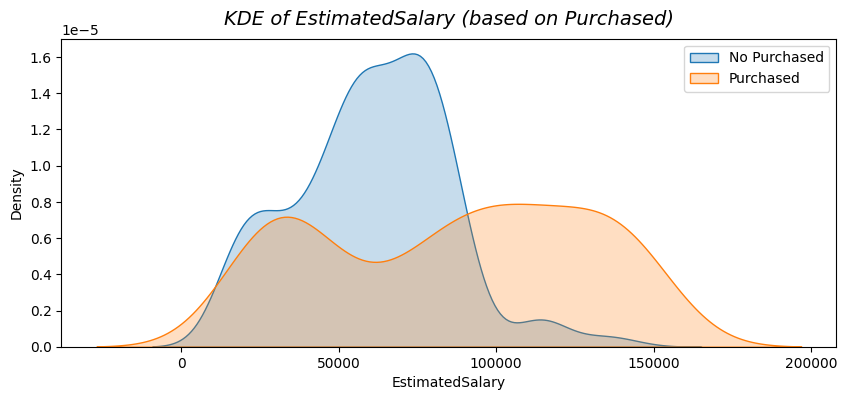

In [27]:

font = {'fontsize':14, 'fontstyle':'italic'}

plt.figure(figsize=(10,4))
sns.kdeplot(df.loc[df['Purchased'] == 0, 'EstimatedSalary'], label='No Purchased', fill=True)
sns.kdeplot(df.loc[df['Purchased'] == 1, 'EstimatedSalary'], label='Purchased', fill=True)
plt.title('KDE of EstimatedSalary (based on Purchased)', fontdict=font, pad=10)
plt.legend()
plt.show()


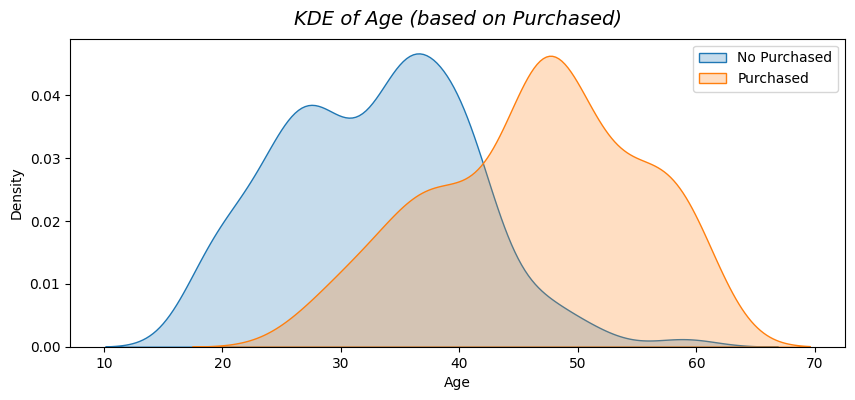

In [28]:

plt.figure(figsize=(10,4))
sns.kdeplot(df.loc[df['Purchased'] == 0, 'Age'], label='No Purchased', fill=True)
sns.kdeplot(df.loc[df['Purchased'] == 1, 'Age'], label='Purchased', fill=True)
plt.title('KDE of Age (based on Purchased)', fontdict=font, pad=10)
plt.legend()
plt.show()


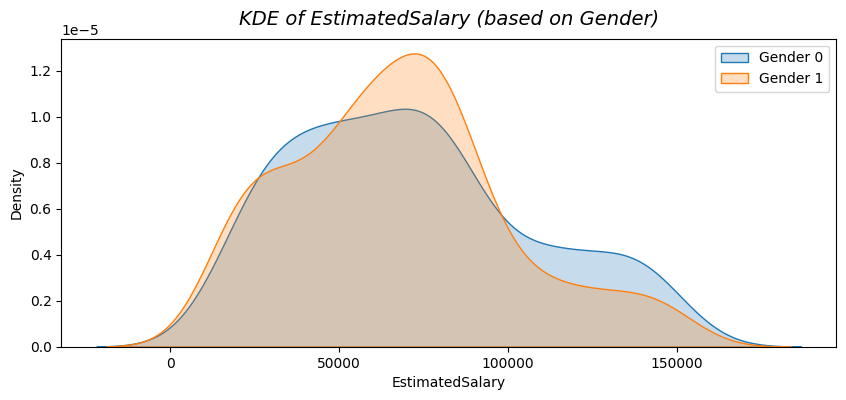

In [29]:

plt.figure(figsize=(10,4))
sns.kdeplot(df.loc[df['Gender'] == df['Gender'].min(), 'EstimatedSalary'], label='Gender 0', fill=True)
sns.kdeplot(df.loc[df['Gender'] == df['Gender'].max(), 'EstimatedSalary'], label='Gender 1', fill=True)
plt.title('KDE of EstimatedSalary (based on Gender)', fontdict=font, pad=10)
plt.legend()
plt.show()


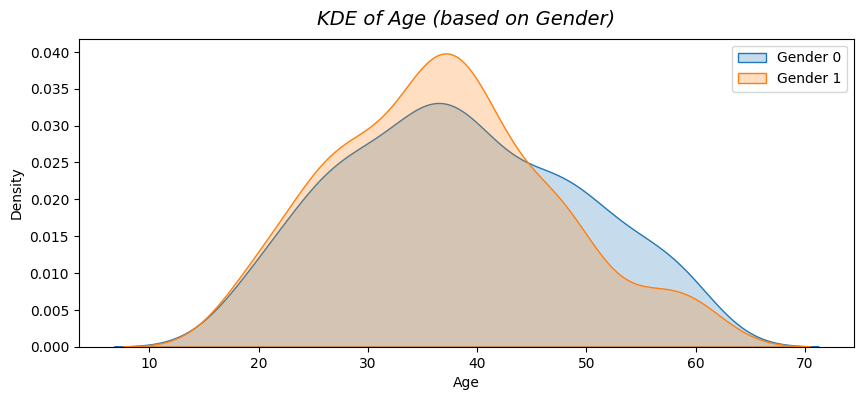

In [30]:

plt.figure(figsize=(10,4))
sns.kdeplot(df.loc[df['Gender'] == df['Gender'].min(), 'Age'], label='Gender 0', fill=True)
sns.kdeplot(df.loc[df['Gender'] == df['Gender'].max(), 'Age'], label='Gender 1', fill=True)
plt.title('KDE of Age (based on Gender)', fontdict=font, pad=10)
plt.legend()
plt.show()


## Langkah 5 — Preprocessing (Scaling) + Modeling (GaussianNB)
Untuk dataset numerik (Age, EstimatedSalary), sesuai instruksi TA-11 gunakan **Gaussian Naive Bayes**.
Dan karena GaussianNB sensitif skala, lakukan **StandardScaler** pada fitur numerik.

In [31]:

# Split X dan y
X = df.drop('Purchased', axis=1)
y = df['Purchased']

# Scaling (krusial untuk GaussianNB)
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['Age', 'EstimatedSalary']] = scaler.fit_transform(X[['Age', 'EstimatedSalary']])

# Train-test split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


X_train: (320, 3) X_test: (80, 3)
y_train: (320,) y_test: (80,)


In [32]:

# Train model
model = GaussianNB()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
acc = metrics.accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
cm


Accuracy: 0.875


array([[47,  4],
       [ 6, 23]])

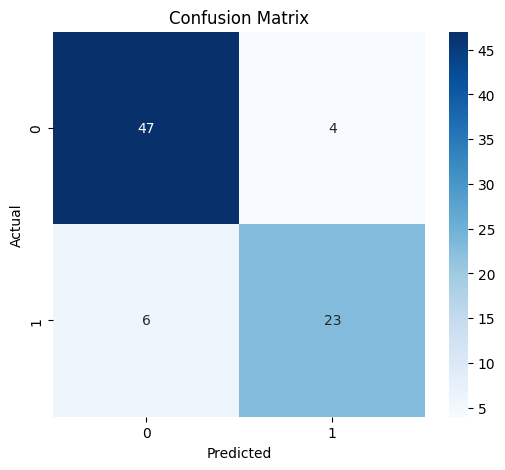

                precision    recall  f1-score   support

No Purchased=0       0.89      0.92      0.90        51
   Purchased=1       0.85      0.79      0.82        29

      accuracy                           0.88        80
     macro avg       0.87      0.86      0.86        80
  weighted avg       0.87      0.88      0.87        80



In [33]:

# Confusion Matrix (heatmap)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(metrics.classification_report(y_test, y_pred, target_names=['No Purchased=0', 'Purchased=1']))


## Langkah 6 — Analisis Probabilitas (`predict_proba`)
Ambil 1 sampel dari data test dan tampilkan probabilitasnya. Kalau ada sampel yang salah prediksi, kita coba pilih yang salah agar analisis lebih menarik.

In [34]:

# Cari sampel yang salah prediksi (jika ada)
mis_idx = np.where(y_pred != y_test.values)[0]

if len(mis_idx) > 0:
    idx = mis_idx[0]
    print("Ada sampel salah prediksi. Pakai indeks test:", idx)
else:
    idx = 0
    print("Tidak ada sampel salah prediksi di test set (pada split ini). Pakai indeks test 0.")

sample = X_test.iloc[[idx]]
true_label = y_test.iloc[idx]

print("Sample features:\n", sample)
print("True label:", true_label)
print("Pred label:", model.predict(sample)[0])
print("Predict_proba [P(class0), P(class1)]:", model.predict_proba(sample)[0])


Ada sampel salah prediksi. Pakai indeks test: 3
Sample features:
      Gender       Age  EstimatedSalary
234       0  0.032952         1.240885
True label: 0
Pred label: 1
Predict_proba [P(class0), P(class1)]: [0.31979711 0.68020289]


## Langkah 7 — Simulasi Data Dummy (Kontras)
Sesuai TA-11: buat 2 data dummy kontras, misalnya:
- User A: Umur muda, gaji tinggi
- User B: Umur tua, gaji rendah
Lalu bandingkan `predict` dan `predict_proba`.

In [35]:

# Buat 2 data dummy kontras (Gender: pakai 0/1 sesuai encoding tadi)
dummy_raw = pd.DataFrame({
    'Gender': [0, 1],
    'Age': [22, 55],
    'EstimatedSalary': [120000, 30000]
})

# Scaling dummy dengan scaler yang sama
dummy = dummy_raw.copy()
dummy[['Age', 'EstimatedSalary']] = scaler.transform(dummy[['Age', 'EstimatedSalary']])

pred_class = model.predict(dummy)
pred_proba = model.predict_proba(dummy)

result = dummy_raw.copy()
result['PredictedClass'] = pred_class
result['P(class0_NoPurchase)'] = pred_proba[:,0]
result['P(class1_Purchase)'] = pred_proba[:,1]

result


,Gender,Age,EstimatedSalary,PredictedClass,P(class0_NoPurchase),P(class1_Purchase)
0,0,22,120000,0,0.789109,0.210891
1,1,55,30000,1,0.131081,0.868919


## Langkah 8 — ROC Curve

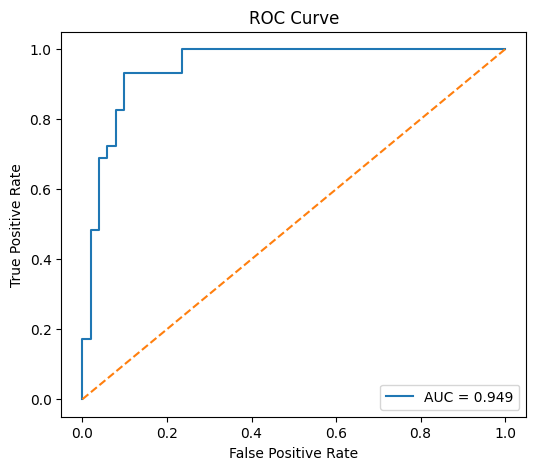

In [36]:

y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## Analisis Hasil


In [37]:
import plotly.express as px
import plotly.io as pio

# Buat dataframe untuk visualisasi dari X_test dan y_test
viz_df = X_test.copy()
viz_df['Purchased'] = y_test.values

# Prediksi kelas untuk X_test
viz_df['Predicted'] = model.predict(X_test).astype(str)

viz_df.head()


,Gender,Age,EstimatedSalary,Purchased,Predicted
331,0,0.988083,1.446439,1,1
92,1,-1.113206,-1.607506,0,0
1,1,-0.253587,-1.460681,0,0
234,0,0.032952,1.240885,0,1
136,0,-1.686284,0.359940,0,0


In [38]:
fig = px.scatter_3d(
    data_frame=viz_df,
    x='Age',
    y='EstimatedSalary',
    z='Purchased',
    color='Predicted',
    opacity=0.6,
    height=700,
    title='Visualization Performance of GaussianNB in Predicting (Test Set)'
)

pio.show(fig)

In [39]:
# Fit final model pada seluruh data (train + test)
final_model = GaussianNB()
final_model.fit(X_scaled, y)  # X_scaled dari scaling sebelumnya

GaussianNB()

In [40]:
# Sample data baru
new_sample_raw = pd.DataFrame({
    'Gender': [1],
    'Age': [18],
    'EstimatedSalary': [70000]
})

print("DATA BARU (SEBELUM SCALING):")
print(new_sample_raw)

# Scaling fitur numerik (Age & EstimatedSalary) pakai scaler yang sama
new_sample = new_sample_raw.copy()
new_sample[['Age', 'EstimatedSalary']] = scaler.transform(new_sample[['Age', 'EstimatedSalary']])

# Prediksi
pred_class = final_model.predict(new_sample)[0]
pred_proba = final_model.predict_proba(new_sample)[0]

print("\nHASIL PREDIKSI:")
print("Predicted class:", pred_class)
print("Predict_proba [P(NoPurchase=0), P(Purchase=1)]:", pred_proba)


DATA BARU (SEBELUM SCALING):
   Gender  Age  EstimatedSalary
0       1   18            70000

HASIL PREDIKSI:
Predicted class: 0
Predict_proba [P(NoPurchase=0), P(Purchase=1)]: [0.99361007 0.00638993]
